In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import pickle
from pathlib import Path

In [2]:
# read dataset
df = pd.read_csv('E://EGY/DATA/cust_segmentation.csv')

## Understanding Data

In [3]:
# shape of data
print(df.shape)
df.head()

(50, 7)


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206


Data tersebut memiliki tujuh kolom dengan penjelasan sebagai berikut:

1. Customer ID: Kode pelanggan dengan format campuran teks CUST- diikuti angka
2. Nama Pelanggan: Nama dari pelanggan dengan format teks tentunya
3. Jenis Kelamin: Jenis kelamin dari pelanggan, hanya terdapat dua isi data kategori yaitu Pria dan Wanita
4. Umur: Umur dari pelanggan dalam format angka
5. Profesi: Profesi dari pelanggan, juga bertipe teks kategori yang terdiri dari Wiraswasta, Pelajar, Professional, Ibu Rumah Tangga, dan Mahasiswa.
6. Tipe Residen: Tipe tempat tinggal dari pelanggan kita, untuk dataset ini hanya ada dua kategori: Cluster dan Sector.
7. Nilai Belanja Setahun: Merupakan total belanja yang sudah di keluarkan oleh pelanggan tersebut.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer_ID          50 non-null     object
 1   Nama Pelanggan       50 non-null     object
 2   Jenis Kelamin        50 non-null     object
 3   Umur                 50 non-null     int64 
 4   Profesi              50 non-null     object
 5   Tipe Residen         50 non-null     object
 6   NilaiBelanjaSetahun  50 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 2.9+ KB


Kita memiliki 50 baris data dan 7 kolom, dengan CustomerID dan Nama pelanggan adalah bertipe objeck atau bisa juga string, Jenis Kelamin, Profesi, Tipe Residen merupakan data bertipe kategori, Umur dan NilaiBelanjaSetahun merupakan data bertipe numerikal atau integer. Tidak terdapat nilai values pada data. 

In [5]:
# Definisikan data numerik dan kategorikal
df_num = df[['Umur', 'NilaiBelanjaSetahun']]
df_cat = df[['Jenis Kelamin', 'Profesi', 'Tipe Residen']]

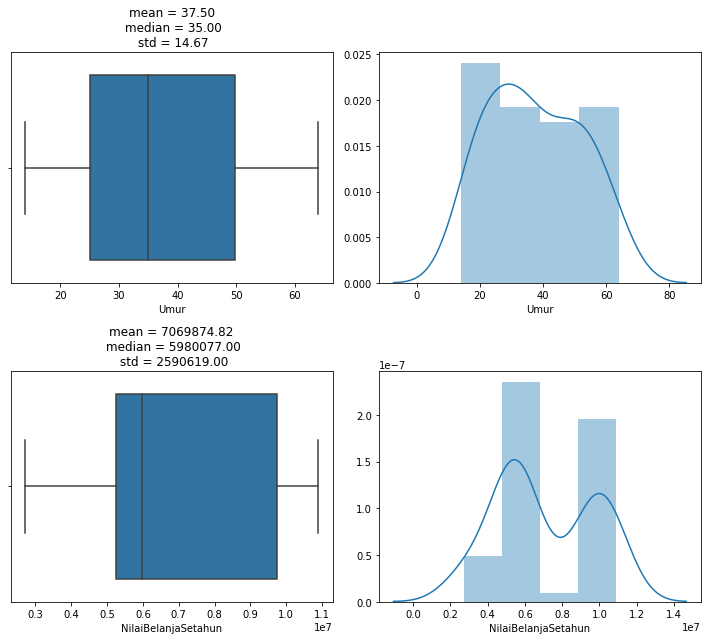

In [6]:
# Fungsi untuk membuat plot  
fig, axs = plt.subplots(2, 2, figsize=(10, 9))
for i, kol in enumerate(df_num):
    sns.boxplot(df[kol], ax = axs[i][0])
    sns.distplot(df[kol], ax = axs[i][1])
    axs[i][0].set_title('mean = %.2f\n median = %.2f\n std = %.2f'%(df[kol].mean(), df[kol].median(), df[kol].std()))
plt.tight_layout()
plt.show()

In [7]:
# cek unique values di kolom kategorikal
for kol in df_cat.columns:
    print(df[kol].unique())

['Pria' 'Wanita']
['Wiraswasta' 'Pelajar' 'Professional' 'Ibu Rumah Tangga' 'Mahasiswa']
['Sector' 'Cluster']


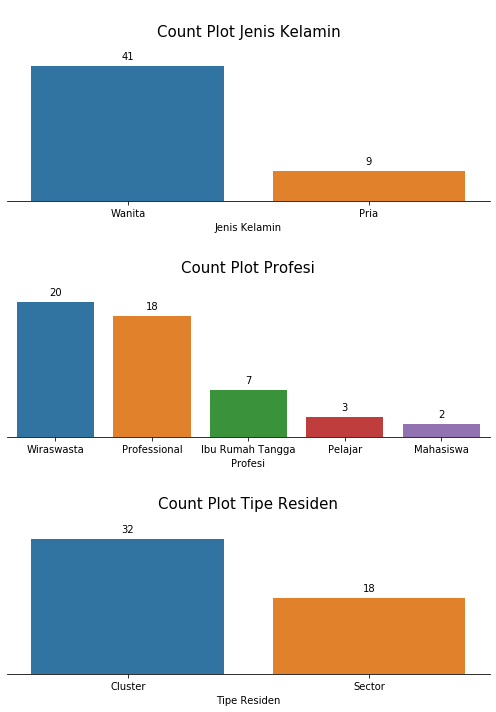

In [8]:
# Membuat plot untuk setiap kolom kategorikal
fig, axs = plt.subplots(3,1,figsize=(7,10)) 
for i, kol in enumerate(df_cat):
    # Membuat Plot
    sns.countplot(df[kol], order = df[kol].value_counts().index, ax = axs[i])  
    axs[i].set_title('\nCount Plot %s\n'%(kol), fontsize=15)  
      
    # Memberikan anotasi  
    for p in axs[i].patches:  
        axs[i].annotate(format(p.get_height(), '.0f'),  
                        (p.get_x() + p.get_width() / 2., p.get_height()),  
                        ha = 'center',  
                        va = 'center',  
                        xytext = (0, 10),  
                        textcoords = 'offset points') 
          
    # Setting Plot  
    sns.despine(right=True,top = True, left = True)  
    axs[i].axes.yaxis.set_visible(False) 
    plt.tight_layout()

# Tampilkan plot
plt.show()

Interpretasi: 
1. Rata-rata umur dari sampel customer adalah 37, mayoritas customer berumur antara 20 smapai 60 tahun. 
2. Rata-rata nilai belanja dalam setahun yang dihabiskan oleh seorang customer adalah sebesar Rp. 7.069.874,-. Mayoritas customer menghabiskan uang mereka untuk berbelanja dalam setahun sebesar Rp.6.000.000,-. Namun banyak juga customer yang menghabiskan uang mereka dalam setahun sebesar Rp. 10.000.000,- 
3. Kebanyakan sampel customer adalah wanita yaitu sebanyak 41 orang. 
4. Mayoritas customer bekerja sebagai wiraswasta dan profesional. 
5. Mayoritas pelangggan memiliki tipe tempat tinggal residen. 

## Feature Engineer

In [9]:
# Data Numerik
print(df_num.head())

   Umur  NilaiBelanjaSetahun
0    58              9497927
1    14              2722700
2    48              5286429
3    53              5204498
4    41             10615206


Data Umur dan NilaiBelanjaSetahun merupakan data numerik dengan skala yang berbeda sehingga kita perlu menyamakan skala dari kedua kolom tersebut supaya hasil pengelompokkan dari data menjadi akurat dan tidak bias. 

In [10]:
# ubah Umur dan NilaiBelanjaSetahun ke dalam skala yang sama 
scaler = StandardScaler()
df_num_scal = scaler.fit_transform(df_num)

In [11]:
# bentuk kembali menjadi dataframe 
df_num_scal = pd.DataFrame(data=df_num_scal, index=df.index, columns=df_num.columns) 

In [12]:
df_num_scal.head()

,Umur,NilaiBelanjaSetahun
0,1.411245,0.946763
1,-1.617768,-1.695081
2,0.722833,-0.695414
3,1.067039,-0.727361
4,0.240944,1.382421


In [13]:
round(df_num_scal.describe(), 1)

,Umur,NilaiBelanjaSetahun
count,50.0,50.0
mean,0.0,-0.0
std,1.0,1.0
min,-1.6,-1.7
25%,-0.9,-0.7
50%,-0.2,-0.4
75%,0.8,1.0
max,1.8,1.5


In [14]:
# Merubah kolom kategorikal menjadi angka 
# df_encode copy
df_encode = df_cat.copy()

# Melakukan labelEncoder untuk semua kolom kategorikal
for col in df_cat:
    df_encode[col]= LabelEncoder().fit_transform(df_encode[col])

# Menampilkan data  
print(df_encode.head())

   Jenis Kelamin  Profesi  Tipe Residen
0              0        4             1
1              1        2             0
2              0        3             0
3              0        3             0
4              1        4             0


In [15]:
# Menggabungkan data numerik dan data kategorikal untuk preprocessing 
df_model = df_encode.merge(df_num_scal, left_index=True, right_index = True, how = 'left')
df_model.head()

,Jenis Kelamin,Profesi,Tipe Residen,Umur,NilaiBelanjaSetahun
0,0,4,1,1.411245,0.946763
1,1,2,0,-1.617768,-1.695081
2,0,3,0,0.722833,-0.695414
3,0,3,0,1.067039,-0.727361
4,1,4,0,0.240944,1.382421


## Building Model

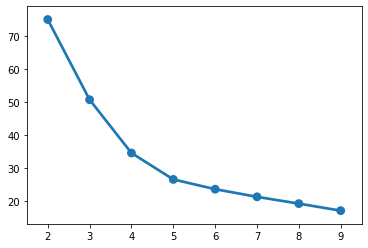

In [16]:
# Mencari jumlah cluster yang optimal 
# Melakukan Iterasi untuk Mendapatkan nilai Cost  
cost = {}  
for k in range(2,10):  
    kproto = KPrototypes(n_clusters = k,random_state=75)  
    kproto.fit_predict(df_model, categorical=[0,1,2])  
    cost[k]= kproto.cost_  

    # Memvisualisasikan Elbow Plot  
sns.pointplot(x=list(cost.keys()), y=list(cost.values()))  
plt.show()

Dari hasil tersebut, terlihat bahwa titik siku dari plot tersebut adalah pada saat k = 5. Sehingga jumlah cluster yang akan digunakan adalah sebanyak 5 cluster. 

In [17]:
# membangun model 
kproto = KPrototypes(n_clusters=5, random_state = 75)
kproto = kproto.fit(df_model, categorical=[0,1,2])
  
#Save Model  
pickle.dump(kproto, open('cluster.pkl', 'wb'))

In [18]:
# Menentukan segmen tiap pelanggan    
clusters =  kproto.predict(df_model, categorical=[0,1,2])    
print('segmen pelanggan: {}\n'.format(clusters))    
    
# Menggabungkan data awal dan segmen pelanggan    
df_final = df.copy()    
df_final['cluster'] = clusters
df_final.head()

segmen pelanggan: [1 2 4 4 0 3 1 4 3 3 4 4 1 1 0 3 3 4 0 2 0 4 3 0 0 4 0 3 4 4 2 1 2 0 3 0 3
 1 3 2 3 0 3 0 3 0 4 1 3 1]



,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927,1
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700,2
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429,4
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498,4
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206,0


In [19]:
# Menampilkan data pelanggan berdasarkan cluster nya  
for i in range (0,5):  
    print('\nPelanggan cluster: {}\n'.format(i))  
    print(df_final[df_final['cluster']== i])


Pelanggan cluster: 0

   Customer_ID       Nama Pelanggan Jenis Kelamin  Umur     Profesi  \
4     CUST-005  Ibu Sri Wahyuni, IR        Wanita    41  Wiraswasta   
14    CUST-015     Shirley Ratuwati        Wanita    20  Wiraswasta   
18    CUST-019         Mega Pranoto        Wanita    32  Wiraswasta   
20    CUST-021     Lestari Fabianto        Wanita    38  Wiraswasta   
23    CUST-024        Putri Ginting        Wanita    39  Wiraswasta   
24    CUST-025       Julia Setiawan        Wanita    29  Wiraswasta   
26    CUST-027        Grace Mulyati        Wanita    35  Wiraswasta   
33    CUST-034       Deasy Arisandi        Wanita    21  Wiraswasta   
35    CUST-036       Ni Made Suasti        Wanita    30  Wiraswasta   
41    CUST-042         Yuliana Wati        Wanita    26  Wiraswasta   
43    CUST-044                 Anna        Wanita    18  Wiraswasta   
45    CUST-046         Elfira Surya        Wanita    25  Wiraswasta   

   Tipe Residen  NilaiBelanjaSetahun  cluster  
4    

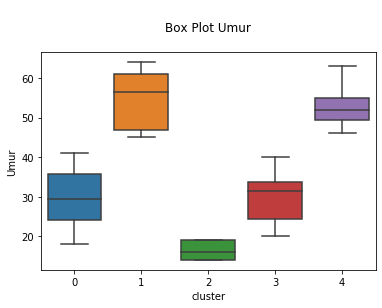

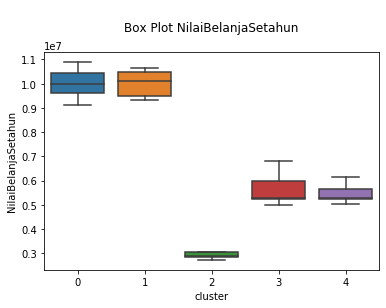

In [20]:
# visualisasi hasil cluster 
# data numerik
df_num = df_final[['Umur','NilaiBelanjaSetahun']]
for i in df_num:  
    plt.figure(figsize=(6,4))  
    ax = sns.boxplot(x = 'cluster',y = i, data = df_final)  
    plt.title('\nBox Plot {}\n'.format(i), fontsize=12)  
    plt.show() 

In [21]:
# Rata-rata tiap kluster 
rata_rata_umur = df_final.groupby(['cluster'])['Umur'].mean()
print('Rata-rata Umur pada tiap cluster:', rata_rata_umur)
print()
rata_rata_belanja = df_final.groupby(['cluster'])['NilaiBelanjaSetahun'].mean()
print('Rata-rata NilaiBelanjaSetahun pada tiap cluster:', round(rata_rata_belanja), 7)

Rata-rata Umur pada tiap cluster: cluster
0    29.500000
1    54.875000
2    16.400000
3    30.071429
4    52.636364
Name: Umur, dtype: float64

Rata-rata NilaiBelanjaSetahun pada tiap cluster: cluster
0     9995179.0
1    10030040.0
2     2914420.0
3     5625972.0
4     5452324.0
Name: NilaiBelanjaSetahun, dtype: float64 7


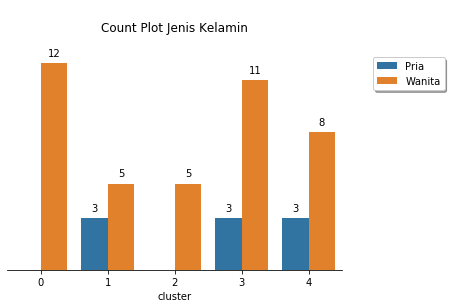

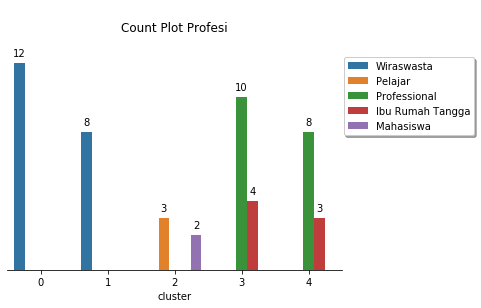

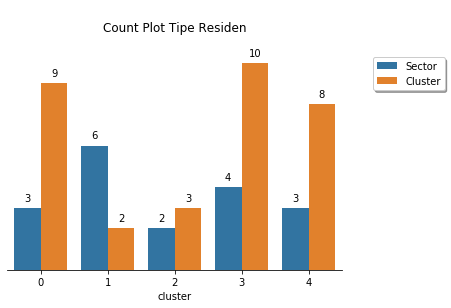

In [22]:
# data kategorikal
df_cat = df_final[['Jenis Kelamin','Profesi','Tipe Residen']]
for i in df_cat:
    plt.figure(figsize=(6,4))  
    ax = sns.countplot(data = df_final, x = 'cluster', hue = i )  
    plt.title('\nCount Plot {}\n'.format(i), fontsize=12)  
    ax.legend(loc = 'upper center', bbox_to_anchor = (1.2,1), shadow = True)  
    for p in ax.patches:  
        ax.annotate(format(p.get_height(), '.0f'),  
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                     ha = 'center',  
                     va = 'center',  
                     xytext = (0, 10),  
                     textcoords = 'offset points')  
      
    sns.despine(right=True,top = True, left = True)  
    ax.axes.yaxis.set_visible(False)  
    plt.show()  

Dari hasil observasi yang dilakukan kita dapat memberikan nama segmen dari tiap tiap nomor kluster nya. Yaitu:

1. Cluster 0: Isi cluster ini adalah para wiraswasta yang memiliki nilai transaksi rata-rata mendekati 10 juta. Selain itu isi dari cluster ini memiliki umur sekitar 18 - 41 tahun dengan rata-ratanya adalah 29 tahun. Diberi nama Diamond Young Entrepreneur. 
2. Cluster 1: Isi cluster ini adalah para wiraswata yang memiliki nilai transaksi rata-rata mendekati 10 juta. Isi dari cluster ini memiliki umur sekitar 45 - 64 tahun dengan rata-ratanya adalah 55 tahun. DIberi nama Diamond Senior Entrepreneur
3. Cluster 2: Isi cluster ini adalah para pelajar dan mahasiswa dengan rata-rata umur mereka adalah 16 tahun dan nilai belanja setahun mendekati 3 juta. Diberi nama Silver Students
4. Cluster 3: Isi cluster ini adalah para professional dan ibu rumah tangga yang berusia muda dengan rentang umur sekitar 20 - 40 tahun dan dengan rata-rata 30 tahun dan nilai belanja setahun nya mendekati 6 juta. Diberi nama Gold Young Member
5. Cluster 4: Isi cluster ini adalah para professional dan ibu rumah tangga yang berusia tua dengan rentang umur 46 - 63 tahun dan dengan rata-rata 53 tahun dan nilai belanja setahun nya mendekati 6 juta. Diberi nama Gold Senior Member

In [23]:
# Mapping nama kolom  
df_final['segmen'] = df_final['cluster'].map({  
    0: 'Diamond Young Member',  
    1: 'Diamond Senior Member',  
    2: 'Silver Member',  
    3: 'Gold Young Member',  
    4: 'Gold Senior Member'  
})  

print(df_final.info())
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer_ID          50 non-null     object
 1   Nama Pelanggan       50 non-null     object
 2   Jenis Kelamin        50 non-null     object
 3   Umur                 50 non-null     int64 
 4   Profesi              50 non-null     object
 5   Tipe Residen         50 non-null     object
 6   NilaiBelanjaSetahun  50 non-null     int64 
 7   cluster              50 non-null     uint16
 8   segmen               50 non-null     object
dtypes: int64(2), object(6), uint16(1)
memory usage: 3.3+ KB
None


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster,segmen
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927,1,Diamond Senior Member
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700,2,Silver Member
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429,4,Gold Senior Member
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498,4,Gold Senior Member
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206,0,Diamond Young Member


## Conclusion 

Data dari customer segmentation yang berjumlah 50 buah sampel data yang berisi data dari tiap customer dapat di kelompokkan kedalam 5 cluster segmentation. Kelima cluster tersebut adalah: 
1. Cluster 0: Diamond Young Entrepreneur, isi cluster ini adalah para wiraswasta yang memiliki nilai transaksi rata-rata mendekati 10 juta. Selain itu isi dari cluster ini memiliki umur sekitar 18 - 41 tahun dengan rata-ratanya adalah 29 tahun.
2. Cluster 1: Diamond Senior Entrepreneur, isi cluster ini adalah para wiraswata yang memiliki nilai transaksi rata-rata mendekati 10 juta. Isi dari cluster ini memiliki umur sekitar 45 - 64 tahun dengan rata-ratanya adalah 55 tahun.
3. Cluster 2: Silver Students, isi cluster ini adalah para pelajar dan mahasiswa dengan rata-rata umur mereka adalah 16 tahun dan nilai belanja setahun mendekati 3 juta.
4. Cluster 3: Gold Young Member, isi cluster ini adalah para professional dan ibu rumah tangga yang berusia muda dengan rentang umur sekitar 20 - 40 tahun dan dengan rata-rata 30 tahun dan nilai belanja setahun nya mendekati 6 juta.
5. Cluster 4: Gold Senior Member, isi cluster ini adalah para professional dan ibu rumah tangga yang berusia tua dengan rentang umur 46 - 63 tahun dan dengan rata-rata 53 tahun dan nilai belanja setahun nya mendekati 6 juta.